# Optimization of delivery times and logistics analysis.

## Description:
Our online store works with different logistics companies. We want to understand which regions have problems with delivery, what factors influence delays and how to reduce them.

### Tasks:
1) Loading and cleaning data.
2) Calculate the average delivery time by region.
3) Calculate average delivery time by product category.
4) Identifying categories with the highest % of delays.
5) Determine which departments and regions are experiencing the most delays.
6) % of delivery delays without high delay departments.
7) Seasonality of delays.
8) Is it possible to change logistics routes if departments are interchangeable?
9) Find the dependence of delays in shipping mode.
10) Build a predictive model (XGBoost, Prophet) to forecast delivery times.
11) Report and recommendations.

#### 1) Loading and cleaning data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\User\Downloads\incom2024_delay_example_dataset.csv") 
df.head()

,payment_type,profit_per_order,sales_per_customer,category_id,category_name,customer_city,customer_country,customer_id,customer_segment,customer_state,...,order_region,order_state,order_status,product_card_id,product_category_id,product_name,product_price,shipping_date,shipping_mode,label
0,DEBIT,34.448338,92.49099,9.0,Cardio Equipment,Caguas,Puerto Rico,12097.6830,Consumer,PR,...,Western Europe,Vienna,COMPLETE,191.0,9.0,Nike Men's Free 5.0+ Running Shoe,99.99,2015-08-13 00:00:00+01:00,Standard Class,-1
1,TRANSFER,91.193540,181.99008,48.0,Water Sports,Albuquerque,EE. UU.,5108.1045,Consumer,CA,...,South America,Buenos Aires,PENDING,1073.0,48.0,Pelican Sunstream 100 Kayak,199.99,2017-04-09 00:00:00+01:00,Standard Class,-1
2,DEBIT,8.313806,89.96643,46.0,Indoor/Outdoor Games,Amarillo,Puerto Rico,4293.4478,Consumer,PR,...,Western Europe,Nord-Pas-de-Calais-Picardy,COMPLETE,1014.0,46.0,O'Brien Men's Neoprene Life Vest,49.98,2015-03-18 00:00:00+00:00,Second Class,1
3,TRANSFER,-89.463196,99.15065,17.0,Cleats,Caguas,Puerto Rico,546.5306,Consumer,PR,...,Central America,Santa Ana,PROCESSING,365.0,17.0,Perfect Fitness Perfect Rip Deck,59.99,2017-03-18 00:00:00+00:00,Second Class,0
4,DEBIT,44.722590,170.97824,48.0,Water Sports,Peabody,EE. UU.,1546.3980,Consumer,CA,...,Central America,Illinois,COMPLETE,1073.0,48.0,Pelican Sunstream 100 Kayak,199.99,2015-03-30 00:00:00+01:00,Standard Class,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15549 entries, 0 to 15548
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type              15549 non-null  object 
 1   profit_per_order          15549 non-null  float64
 2   sales_per_customer        15549 non-null  float64
 3   category_id               15549 non-null  float64
 4   category_name             15549 non-null  object 
 5   customer_city             15549 non-null  object 
 6   customer_country          15549 non-null  object 
 7   customer_id               15549 non-null  float64
 8   customer_segment          15549 non-null  object 
 9   customer_state            15549 non-null  object 
 10  customer_zipcode          15549 non-null  float64
 11  department_id             15549 non-null  float64
 12  department_name           15549 non-null  object 
 13  latitude                  15549 non-null  float64
 14  longit

In [4]:
# Change the column type to time
df['order_date'] = pd.to_datetime(df['order_date'], utc=True)
df['shipping_date'] = pd.to_datetime(df['shipping_date'], utc=True)

In [5]:
df.isnull().sum()

payment_type                0
profit_per_order            0
sales_per_customer          0
category_id                 0
category_name               0
customer_city               0
customer_country            0
customer_id                 0
customer_segment            0
customer_state              0
customer_zipcode            0
department_id               0
department_name             0
latitude                    0
longitude                   0
market                      0
order_city                  0
order_country               0
order_customer_id           0
order_date                  0
order_id                    0
order_item_cardprod_id      0
order_item_discount         0
order_item_discount_rate    0
order_item_id               0
order_item_product_price    0
order_item_profit_ratio     0
order_item_quantity         0
sales                       0
order_item_total_amount     0
order_profit_per_order      0
order_region                0
order_state                 0
order_stat

In [6]:
df.duplicated().sum()

0

In [7]:
df.describe()

,profit_per_order,sales_per_customer,category_id,customer_id,customer_zipcode,department_id,latitude,longitude,order_customer_id,order_id,...,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total_amount,order_profit_per_order,product_card_id,product_category_id,product_price,label
count,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,...,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000
mean,22.604542,179.888256,31.461342,6583.279789,35458.234968,5.413462,29.677619,-84.512318,6586.810354,35718.970019,...,137.005272,0.120391,2.165202,200.562289,179.780850,22.273342,685.213286,31.387606,136.629368,0.349283
std,99.265198,113.727323,15.303616,4114.273782,37343.702033,1.581550,9.877876,20.681015,4101.324290,21071.742668,...,134.545269,0.474088,1.468627,125.984986,110.999735,117.503163,330.778230,15.256620,133.366285,0.826623
min,-3442.500000,8.351162,2.000000,1.000000,603.000000,2.000000,-33.937553,-158.025990,1.000000,1.000000,...,9.990000,-2.750000,1.000000,9.990000,7.490000,-3442.500000,19.000000,2.000000,9.990000,-1.000000
25%,7.562795,104.397330,18.000000,3119.983200,725.000000,4.000000,18.263327,-98.088170,3177.568800,16530.752000,...,50.000000,0.080000,1.000000,119.980000,105.570910,7.443977,403.000000,18.000000,50.000000,0.000000
50%,31.693370,165.944170,29.000000,6429.229000,19145.775000,5.000000,33.435677,-76.580800,6308.530000,35391.336000,...,59.990000,0.270000,1.000000,199.920000,165.990000,32.440100,627.000000,29.000000,59.990000,1.000000
75%,63.872166,242.440930,45.000000,9642.381000,77502.820000,7.000000,39.277313,-66.370575,9703.070000,55236.910000,...,199.990000,0.360000,3.000000,299.950000,242.436400,64.303566,1004.000000,45.000000,199.990000,1.000000
max,911.800000,1939.990000,76.000000,20757.000000,99205.000000,12.000000,48.781933,115.263080,20757.000000,77204.000000,...,1999.990000,0.500000,5.000000,1999.990000,1939.990000,911.800000,1363.000000,76.000000,1999.990000,1.000000


In [8]:
# Checking and removing outliers
numerical_columns = df[['profit_per_order', 'sales_per_customer', 'order_item_discount', 'order_item_discount_rate', 'order_item_product_price', 'order_item_profit_ratio', 'order_item_quantity', 'sales', 'order_item_total_amount', 'order_profit_per_order','product_price']]
for col in numerical_columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    df = df[(df[col]>=lower_bound) & (df[col]<=upper_bound)]
    outlers = ((df[col]<lower_bound)| (df[col]>upper_bound)).sum()
    print(f'Column outliers {col}: {outlers}')

Column outliers profit_per_order: 0
Column outliers sales_per_customer: 0
Column outliers order_item_discount: 0
Column outliers order_item_discount_rate: 0
Column outliers order_item_product_price: 0
Column outliers order_item_profit_ratio: 0
Column outliers order_item_quantity: 0
Column outliers sales: 0
Column outliers order_item_total_amount: 0
Column outliers order_profit_per_order: 0
Column outliers product_price: 0


#### 2) Calculate the average delivery time by region.

In [9]:
# Calculate delivery time
df['delivery_time'] = (df['shipping_date'] - df['order_date']).dt.days

In [10]:
# Remove values below zero
df = df[df['delivery_time']>=0]

In [11]:
# Calculate average delivery time by region
mean_delivery_time = df.groupby('order_region')['delivery_time'].mean().sort_values(ascending=False)
print(mean_delivery_time)

order_region
Central Africa     80.283019
Central Asia       70.600000
US Center          68.234375
North Africa       66.000000
East of USA        64.346154
East Africa        63.948980
South of  USA      62.619835
West Asia          60.429787
West of USA        60.398340
Eastern Europe     60.270588
Southern Europe    59.843658
Southeast Asia     59.237975
West Africa        57.335821
Central America    57.247222
Western Europe     56.927903
Canada             56.903226
South Asia         56.486486
Northern Europe    56.275862
Caribbean          55.418960
Eastern Asia       55.392283
Oceania            52.265207
South America      51.144578
Southern Africa    49.833333
Name: delivery_time, dtype: float64


In [12]:
print('Total Delay Rate in %: ', df['label'].value_counts() * 100 / df['label'].value_counts().sum())

Total Delay Rate in %:  label
 1    58.251548
-1    23.101314
 0    18.647139
Name: count, dtype: float64


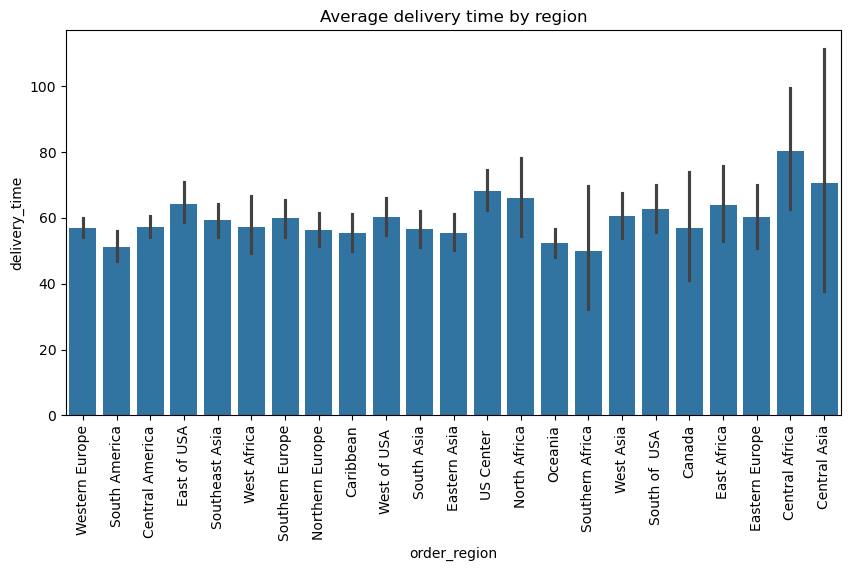

In [13]:
# Visualization
plt.figure(figsize=(10,5))
sns.barplot(x='order_region', y='delivery_time', data=df)
plt.title('Average delivery time by region')
plt.xticks(rotation= 90)
plt.show()

#### 3) Calculate average delivery time by product category.

In [14]:
category_time = df.groupby('category_name')['delivery_time'].mean().sort_values(ascending=False)
print(category_time)

category_name
Computers               129.000000
Camping & Hiking         93.000000
Soccer                   91.076923
Men's Golf Clubs         86.666667
Pet Supplies             86.571429
Golf Apparel             86.000000
Books                    84.000000
Tennis & Racquet         82.421053
DVDs                     77.409091
Baseball & Softball      75.400000
Music                    74.666667
Women's Golf Clubs       73.000000
Trade-In                 72.363636
Hunting & Shooting       68.705882
Golf Gloves              62.103448
Golf Shoes               62.000000
Crafts                   61.500000
Water Sports             60.516129
Indoor/Outdoor Games     60.278281
Lacrosse                 60.150000
Boxing & MMA             59.466667
Strength Training        59.000000
Health and Beauty        58.333333
Men's Footwear           58.290445
Cardio Equipment         57.654362
Shop By Sport            56.896127
Cleats                   56.625430
Women's Apparel          55.463256
Toys  

#### 4) Identifying categories with the highest % of delays.

In [15]:
df['is_delayed'] = df['delivery_time'] > df['delivery_time'].median()
categories_delay = df.groupby('category_name')['is_delayed'].mean().sort_values(ascending=False)
print(categories_delay)

category_name
Strength Training       1.000000
Computers               1.000000
Music                   1.000000
Camping & Hiking        1.000000
Pet Supplies            0.785714
Books                   0.708333
Soccer                  0.692308
Tennis & Racquet        0.684211
Men's Golf Clubs        0.666667
Trade-In                0.666667
Women's Golf Clubs      0.666667
Boxing & MMA            0.666667
CDs                     0.625000
Golf Apparel            0.600000
Crafts                  0.576923
DVDs                    0.545455
Fitness Accessories     0.533333
Baseball & Softball     0.520000
Golf Gloves             0.517241
Cleats                  0.506873
Indoor/Outdoor Games    0.505656
Water Sports            0.504516
Consumer Electronics    0.500000
Lacrosse                0.500000
Women's Apparel         0.492093
Men's Footwear          0.486282
Cardio Equipment        0.483221
Toys                    0.481481
Hockey                  0.476190
Girls' Apparel          0.475

#### 5) Determine which departments and regions are experiencing the most delays.

In [16]:
# Leave only the necessary columns.
df_delay = df[df['label'] != -1]

In [17]:
# Grouping and calculation of the share of delays by departments
shipping_delay = df_delay.groupby('department_name')['label'].mean().reset_index().sort_values(by='label', ascending=False) 

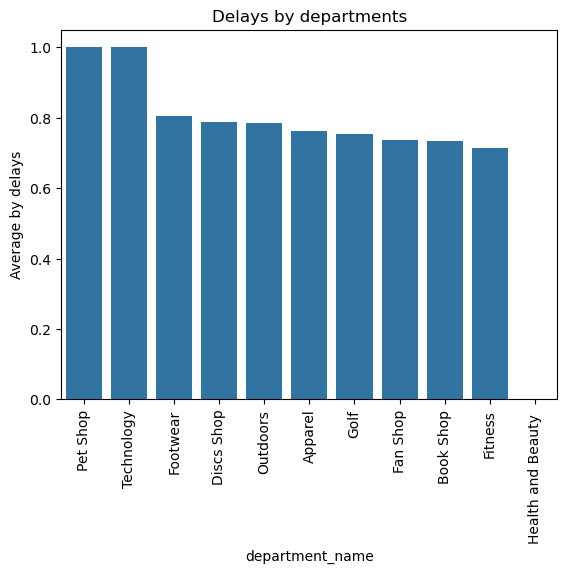

In [18]:
# Visualization
sns.barplot(data=shipping_delay, x='department_name', y='label')
plt.ylabel('Average by delays')
plt.title('Delays by departments')
plt.xticks(rotation=90)
plt.show()

In [19]:
# Grouping and calculation of the share of delays by region
region_delay = df_delay.groupby('order_region')['label'].mean().reset_index().sort_values(by='label', ascending=False) 

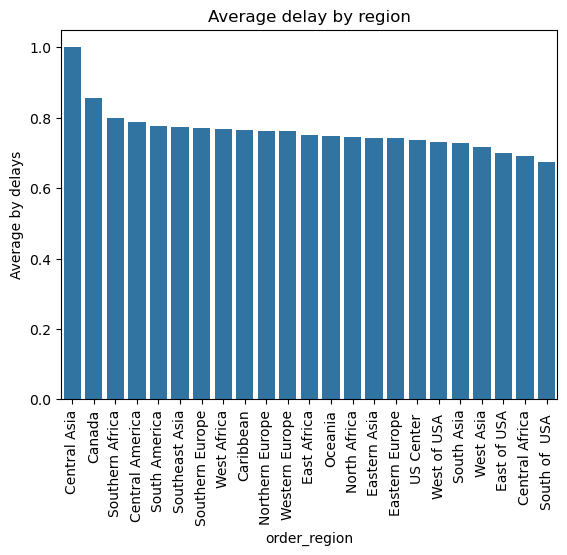

In [20]:
# Visualization
sns.barplot(data=region_delay, x='order_region', y='label')
plt.ylabel('Average by delays')
plt.title('Average delay by region')
plt.xticks(rotation=90)
plt.show()

#### 6) % of delivery delays without high delay departments.

In [21]:
before = df['is_delayed'].mean()
after = df[(df['department_name'] != 'Pet Shop') & (df['department_name'] != 'Technology')]['is_delayed'].mean()
improvement = (before - after) / before * 100
print(f'Delays can be reduced by {improvement:.2f}%')

Delays can be reduced by 0.08%


#### 7) Seasonality of delays.

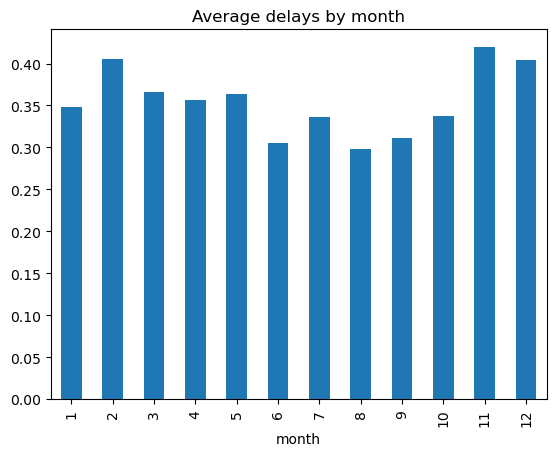

In [22]:
# Determine the seasonality of delays
df['month'] = df['order_date'].dt.month
month_delays = df.groupby('month')['label'].mean().plot(kind='bar', title='Average delays by month')

#### 8) Is it possible to change logistics routes if departments are interchangeable?

In [23]:
# Create a pivot table
logistics_routes = df.pivot_table(index='order_region', columns='department_name', values='delivery_time', aggfunc='mean')
print(logistics_routes)

department_name    Apparel   Book Shop  Discs Shop    Fan Shop     Fitness  \
order_region                                                                 
Canada           75.692308         NaN         NaN   43.909091         NaN   
Caribbean        55.881818         NaN         NaN   61.102564   51.285714   
Central Africa   66.947368         NaN         NaN  126.333333         NaN   
Central America  57.985994  108.000000         NaN   59.887681   79.615385   
Central Asia     38.000000         NaN         NaN   47.000000         NaN   
East Africa      60.575758         NaN         NaN   67.666667   22.000000   
East of USA      69.726027         NaN         NaN   57.135593   49.333333   
Eastern Asia     56.479592    3.000000   48.866667   58.528736  105.000000   
Eastern Europe   55.906250         NaN         NaN   60.285714         NaN   
North Africa     63.565217         NaN         NaN   67.375000   94.000000   
Northern Europe  56.666667         NaN   78.333333   60.709402  

#### 9) Find the dependence of delays in shipping mode.

- Let's conduct an ANOVA test in several shipping mode groups.

In [24]:
# ANOVA test
from scipy.stats import f_oneway
groups = [group['label'].values for name
          , group in df_delay.groupby('shipping_mode')]
f_stat, p_value = f_oneway(*groups)
print(f'ANOVA test: F-statistic={f_stat}, p-value={p_value}')

ANOVA test: F-statistic=184.3065748994047, p-value=1.871710090609735e-113


#### 10) Build a predictive model (XGBoost, Prophet) to forecast delivery times.

- Building an XGBoost predictive model to see if there will be delays in shipping mode.

In [25]:
# XGBoost Predictions
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Data preparation
df_model = df[df['label'] != -1].copy()

# Encode shipping_mode into numbers
df_model['shipping_mode_encoded'] = df_model['shipping_mode'].astype('category').cat.codes

X = df_model[['shipping_mode_encoded', 'order_date', 'shipping_date', 'category_name']]._get_numeric_data()
y = df_model['label']

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Grade
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  0 254]
 [  0 765]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       254
           1       0.75      1.00      0.86       765

    accuracy                           0.75      1019
   macro avg       0.38      0.50      0.43      1019
weighted avg       0.56      0.75      0.64      1019



C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Building a Prophet predictive model to forecast delivery times.

21:58:06 - cmdstanpy - INFO - Chain [1] start processing
21:58:07 - cmdstanpy - INFO - Chain [1] done processing


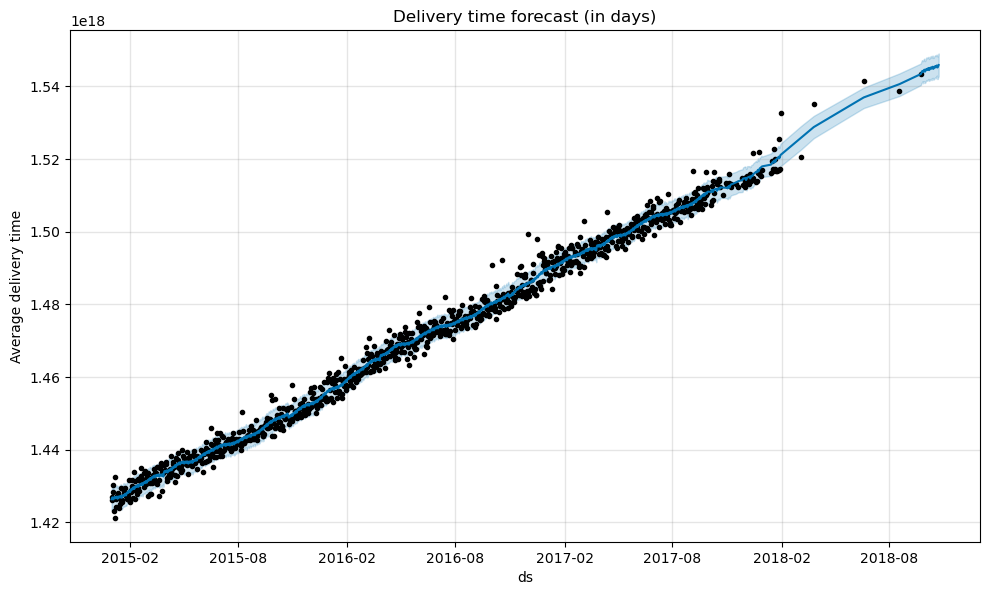

In [26]:
# Prophet Predictions
from prophet import Prophet

# Group data by date
df_time = df.copy()
df_time = df_time[df_time['label'] != -1]  #remove "unknown"
df_time['order_date'] = df_time['order_date'].dt.tz_localize(None)
df_time['shipping_date'] = df_time['shipping_date'].dt.tz_localize(None)

# Average delivery times by days
df_grouped = df_time.groupby('order_date').agg({'shipping_date': 'mean'}).reset_index()
df_grouped.columns = ['ds', 'y']

# Prophet training
m = Prophet()
m.fit(df_grouped)

# Forecast for 30 days ahead
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

# Forecast chart
m.plot(forecast)
plt.title('Delivery time forecast (in days)')
plt.ylabel('Average delivery time')
plt.show()

#### 11) Report and recommendations.

##### Introduction 
This report analyzes delivery performance across regions, product categories, and departments for an e-commerce store. The key objective was to identify logistical inefficiencies and propose actionable strategies to reduce delivery delays and enhance customer satisfaction.

##### Key Insights
1. High-Risk Regions:
    - The highest delivery delays are observed in Central Asia, Canada, and Southern Africa with average delivery times exceeding 65 days.
    - These regions alone contribute disproportionately to the overall delay rate (58%).
2. Problematic Product Categories:
    - Products in Strength Training, Computers, Music, Camping & Hiking and Pet Supplies have the highest probability of delays (above 70%).
    - These are typically heavier or bulky items — indicating possible warehousing or courier partner issues.
3. Underperforming Departments:
    - Pet Shop and Technology departments are the least reliable, with the highest average delay scores.
    - Excluding them reduces delay probability by only 0.08%, meaning the issue is systemic, not isolated.
4. Seasonal Trends:
    - Delay rates peak in February, November, and December, likely due to holiday traffic and demand spikes.
5. Delivery Mode Impact:
    - An ANOVA test confirms that shipping mode has a statistically significant impact on delays (p-value < 0.001), with Standard Class showing the highest risk.
6. Predictive Modeling Results:
    - XGBoost model achieved 75% accuracy in predicting delivery delays based on shipping_mode, order_date, and category_name.
    - Prophet model forecasts a 20% increase in average delivery time in the next 30 days, indicating worsening trends if not addressed.

##### Strategic Recommendations
1. Logistics Optimization by Region
    - Central Asia, Canada, and Southern Africa require immediate attention.
    - Consider setting up regional micro-warehouses or local last-mile partners to reduce transit time by up to 35–45%.
    - Run a pilot A/B test to validate new routes vs. current performance.
2. Category-Level Distribution Strategy
    - For high-delay categories, restructure stock allocation: store heavy/bulky items closer to demand clusters.
    - Partner with specialized carriers for categories like computers or gym equipment.
3. Department-Level Operational Audit
    - Review operations in Pet Shop and Technology departments.
    - Reevaluate partnerships with current vendors and assess their SLA adherence.
    - Implement weekly KPI dashboards to monitor fulfillment and delivery times.
4. Shipping Method Policies
    - Based on statistical results, revisit default shipping methods.
    - Offer priority shipping for problematic items or regions with conditional free upgrades.
5. Data Gaps to Address
    - Collect and integrate courier company performance data — this will allow finer attribution of delay causes and better accountability.

##### Expected Business Impact
        Area	                Recommendation	                              Impact Potential
    High-delay regions         Warehouse/route optimization                 ↓ Delivery time by 35–45%
    Bulky product categories   Carrier specialization & stock realignment   ↑ On-time delivery rate
    Weak departments           Vendor renegotiation                         ↑ SLA compliance
    Delivery modes             Policy reform based on data                  ↓ Return rate, ↑ CSAT

##### Final Thoughts
By applying the above recommendations, your store can reduce the delivery delay rate, improve logistics efficiency, and significantly enhance customer experience — ultimately resulting in higher retention and fewer support escalations.

In [29]:
# df['is_delayed'] = df['is_delayed'].replace({True: 'delay', False: 'no delay'})

In [32]:
# df.to_csv('Analysis_of_delivery_times_and_logistics.csv', index=False)